### Additionally installed libraries

In [ ]:
### Install dependencies:
%%bash
git clone https://github.com/open2c/pairtools.git
cd pairtools
pip install -e .

pip install bioframe pandas cooler

In [ ]:
### Download input data:
! wget https://gitlab.rlp.net/3d-diploid-chromatin/simulation-code/-/raw/main/Simulation_Data/Data/gm12878_17.pairs

### Import dependencies

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pairtools.lib import headerops, fileio

In [3]:
import bioframe
import pandas as pd
import pairtools
import numpy as np
import cooler

In [4]:
# Get chromosome sizes:
genome = "hg19"
chromsizes = bioframe.fetch_chromsizes(genome)[:'chrY']

In [5]:
def phase_chrom_sizes(chromsizes, phases=None):
    """
    Get the dataframe of chromosome sizes for hap- or di-ploid genomes.
    """
    output = pd.DataFrame()
    for phase in phases:
        output_frag = chromsizes.reset_index()
        output_frag.loc[:, 'name'] = output_frag['name'].apply(lambda x: f"{x}_{phase}")
        output = pd.concat([output, output_frag])

    output = output.set_index('name')
    return output

def get_beads_per_chromosomes(chromsizes, resolution):
    output = np.ceil( chromsizes/resolution ).astype(np.int_)
    return output

In [6]:
# Phase chromosome sizes, create diploid genome:
chromsizes_diploid = phase_chrom_sizes(chromsizes, phases=('0', '1'))

# Convert genome to the bin sizes:
resolution = 1_000_000
chromsizes_diploid_res     = get_beads_per_chromosomes(chromsizes_diploid, resolution)
chromsizes_res = get_beads_per_chromosomes(chromsizes, resolution)

In [7]:
# Create diploid viewframe on the genome:
genome_viewframe_diploid = bioframe.make_viewframe(chromsizes_diploid['length'])

In [8]:
# Create bin table:
bin_table = cooler.binnify(chromsizes_diploid['length'], resolution)

### Read contact pairs

In [9]:
# Read scHi-C interaction pairs:
pairs_file = "./gm12878_17.pairs"

pairs_stream = fileio.auto_open(pairs_file, 'r')
header, pairs_stream = headerops.get_header(pairs_stream)
columns = headerops.get_colnames(header)

df = pd.read_table(pairs_stream, comment="#", header=None)
df.columns = columns

# Modify chromosome names:
df.loc[:, 'chr1'] = df.loc[:, 'chr1'].apply(lambda x: f'chr{x}')
df.loc[:, 'chr2'] = df.loc[:, 'chr2'].apply(lambda x: f'chr{x}')

/tmp/ipykernel_2309672/1099055995.py:8: DtypeWarning: Columns (1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_table(pairs_stream, comment="#", header=None)


### Write contacts for a single round of simulations

In [10]:
# bin1_unphased and bin2_unphased are unphased chromosome coordinates.
chr_offsets = chromsizes_res.cumsum().shift(1).replace(np.nan, 0).astype(int)

df.loc[:, 'bin1_unphased'] = df.loc[:, 'pos1']//resolution + df['chr1'].apply(lambda x: chr_offsets[x])
df.loc[:, 'bin2_unphased'] = df.loc[:, 'pos2']//resolution + df['chr2'].apply(lambda x: chr_offsets[x])

In [11]:
df.loc[:, 'chr1_phased'] = df.apply(lambda x: x["chr1"]+str("_"+x["phase0"] if x["phase0"]!='.' else ''), axis=1)
df.loc[:, 'chr2_phased'] = df.apply(lambda x: x["chr2"]+str("_"+x["phase1"] if x["phase1"]!='.' else ''), axis=1)

In [12]:
df.query('phase1!="."').head()

,readID,chr1,pos1,chr2,pos2,strand1,strand2,phase0,phase1,phase_prob00,phase_prob01,phase_prob10,phase_prob11,bin1_unphased,bin2_unphased,chr1_phased,chr2_phased
61,.,chr1,935952,chr1,212526488,-,-,.,1,0.000,0.001,0.000,0.999,0,212,chr1,chr1_1
62,.,chr1,936011,chr1,212526262,+,+,.,1,0.000,0.001,0.000,0.999,0,212,chr1,chr1_1
110,.,chr1,1001028,chr1,2240428,+,-,0,0,1.000,0.000,0.000,0.000,1,2,chr1_0,chr1_0
163,.,chr1,1139664,chr1,53627796,+,+,.,0,0.989,0.000,0.011,0.000,1,53,chr1,chr1_0
164,.,chr1,1139703,chr1,53627671,-,-,.,0,0.989,0.000,0.011,0.000,1,53,chr1,chr1_0


In [13]:
def split_pairs(df, 
                phase_cols=('phase0', 'phase1'),
                accepted_phases=('0', '1'),
                mark=True, col_mark='pair_type'
               ):
    """Split the pairs into ambiguous and non-ambiguous pairs"""

    mask = np.ones(len(df), dtype=np.bool_)
    for phase_col in phase_cols:
        mask &= np.in1d( df.loc[:, phase_col], accepted_phases )
    if mark:
        df.loc[mask, col_mark] = 'accepted'
        df.loc[~mask, col_mark] = 'ambiguous'
    return df[mask], df[~mask], df

def get_edges(df, cols=['bin1_phased', 'bin2_phased'], add_cols=['bin1_unphased', 'bin2_unphased'], drop_self=True):
    df_unique = df.dropna(subset=cols).drop_duplicates(subset=cols)
    if drop_self:
        df_unique = df_unique.query('abs(bin1_phased-bin2_phased)>2')
    return df_unique[cols+add_cols]

In [14]:
# Split pairs into ambiguous vs not: 
df_accepted, df_ambiguous, df = split_pairs(df)
print('Ambiguous vs resolved:', len(df_ambiguous), len(df_accepted))

Ambiguous vs resolved: 1826692 12546


In [15]:
# bin1_phased and bin2_phased are phased binned coordinates
chr_offsets_diploid = chromsizes_diploid_res.cumsum().shift(1).replace(np.nan, 0).astype(int)

df_accepted.loc[:, 'bin1_phased'] = df_accepted.loc[:, 'pos1']//resolution + df_accepted['chr1_phased'].apply(lambda x: chr_offsets_diploid.loc[x, 'length'])
df_accepted.loc[:, 'bin2_phased'] = df_accepted.loc[:, 'pos2']//resolution + df_accepted['chr2_phased'].apply(lambda x: chr_offsets_diploid.loc[x, 'length'])

# Get the edges: 
df_edges = get_edges(df_accepted)

/tmp/ipykernel_2309672/2890387701.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_accepted.loc[:, 'bin1_phased'] = df_accepted.loc[:, 'pos1']//resolution + df_accepted['chr1_phased'].apply(lambda x: chr_offsets_diploid.loc[x, 'length'])
/tmp/ipykernel_2309672/2890387701.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_accepted.loc[:, 'bin2_phased'] = df_accepted.loc[:, 'pos2']//resolution + df_accepted['chr2_phased'].apply(lambda x: chr_offsets_diploid.loc[x, 'length'])


In [16]:
iteration = 1

df_edges.to_csv(f"./edges_round{iteration}.csv")

bin_table.to_csv(f"./bin_table_round{iteration}.csv")
chromsizes_diploid_res.to_csv(f"./chrom-sizes_round{iteration}.csv")

In [17]:
#### Next steps:
# Go from input 3D genome to the set of isolated, resolved and ambiguous contacts

In [18]:
len(df_ambiguous)

1826692

In [19]:
len(df_accepted)

12546

In [20]:
len(df_edges)

2768

In [21]:
df_edges.tail()

,bin1_phased,bin2_phased,bin1_unphased,bin2_unphased
1824148,3013,3040,3013,3040
1828103,3021,3047,3021,3047
1829325,6137,6144,3024,3031
1830276,3026,3031,3026,3031
1831040,3027,3036,3027,3036


## Resolve-remove contact pairs

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

In [82]:
positions_3d = np.load("./hoomd_model_round2.npy")

In [83]:
pos = positions_3d.copy()

In [84]:
def get_distances_backbone(pos, chromsizes_binned):
    """ Return distsnce to the next bead, or nan if current bead is at the end of chromosome"""
    dists = np.linalg.norm(pos[:-1, :] - pos[1:, :], axis=1)
    dists = np.concatenate([dists, [np.nan]])

    # Fill in ends of chromosomes with nans:
    chr_ends = np.concatenate( [chromsizes_binned.values.cumsum(), [len(pos)]] )-1
    dists[chr_ends] = np.nan
    
    return dists

def get_distances_links(df_edges):
    dists = np.linalg.norm( 
        pos[df_edges['bin1_phased'].values.astype(int), :] - \
        pos[df_edges['bin2_phased'].values.astype(int), :], 
        axis=1)
    return dists

In [85]:
distances_backbone = get_distances_backbone(pos, chromsizes_diploid_res)

In [86]:
distances_links = get_distances_links(df_edges)

In [87]:
df_edges.loc[:, 'dist'] = distances_links

In [88]:
pd.Series(distances_backbone).describe()

count    12364.000000
mean         1.002582
std          0.050139
min          0.795462
25%          0.969212
50%          1.002567
75%          1.036336
max          1.184438
dtype: float64

In [109]:
pd.Series(distances_links).describe()

count    4841.000000
mean       10.031245
std        11.585352
min         1.747097
25%         1.991036
50%         2.044670
75%        20.057264
max        44.802559
dtype: float64

In [89]:
df_edges.sort_values('dist').head()

,bin1_phased,bin2_phased,bin1_unphased,bin2_unphased,dist
1214949,3440,12271,3440,6065,1.747097
1439022,10656,10667,4450,4461,1.835512
966362,9005,9058,2799,2852,1.838126
1332506,10227,10366,4021,4160,1.842127
375748,1013,1360,1013,1360,1.845053


(0.0, 50.0)

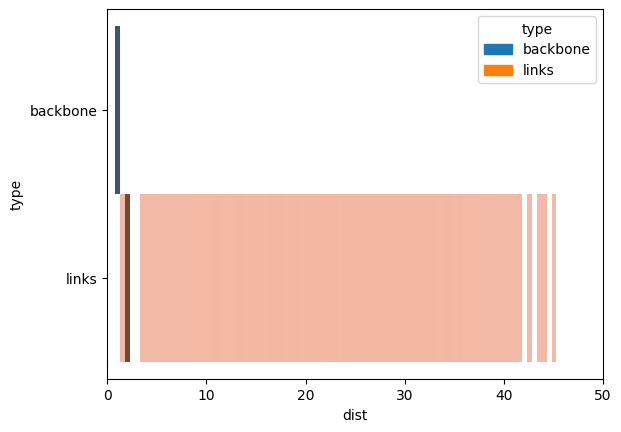

In [90]:
df_dists_toplot = pd.concat([
    pd.DataFrame( [distances_backbone, 
               np.repeat('backbone', len(distances_backbone))], 
                 index=['dist', 'type'] ).T,
    pd.DataFrame( [distances_links, 
               np.repeat('links', len(distances_links))], 
                 index=['dist', 'type'] ).T
    ])

sns.histplot( 
    df_dists_toplot.reset_index(drop=True), 
    binwidth=5e-1,
    x='dist', y='type', hue='type', 
    common_norm=False )

plt.xlim([0, 50])

#### Try phasing ambiguous contacts

In [91]:
def assign_phases(df, phase0=0, phase1=1, filter=True):
    
    if filter:
        cond = (df['phase0']=='.')&(df['phase1']=='.')
        cond |= (df['phase0']=='.')&(df['phase1']==phase1)
        cond |= (df['phase0']==phase0)&(df['phase1']=='.')
        df = df.loc[cond, :].copy()
    
    df.loc[:, 'phase0'] = phase0
    df.loc[:, 'phase1'] = phase1

    phase0_str = "_"+str(phase0)
    phase1_str = "_"+str(phase1)
    
    df.loc[:, 'chr1_phased'] = df.apply(lambda x: x["chr1"]+phase0_str, axis=1)
    df.loc[:, 'chr2_phased'] = df.apply(lambda x: x["chr2"]+phase1_str, axis=1)

    return df

In [92]:
from tqdm.autonotebook import tqdm

In [93]:
# Assign pseudo-phases
# Annotate edges in diploid genome and store them

dfs_pseudophased = {}
for phases in tqdm([
    (0, 0),
    (0, 1),
    (1, 0),
    (1, 1)
]):
    df_pseudophased = assign_phases(df_ambiguous, phase0=phases[0], phase1=phases[1])
    df_pseudophased.loc[:, 'bin1_phased'] = (df_pseudophased.loc[:, 'pos1']//resolution).values + \
                                            chr_offsets_diploid.loc[df_pseudophased['chr1_phased']].values.T[0]
    df_pseudophased.loc[:, 'bin2_phased'] = (df_pseudophased.loc[:, 'pos2']//resolution).values + \
                                            chr_offsets_diploid.loc[df_pseudophased['chr2_phased']].values.T[0]
    df_pseudophased_edges = get_edges(df_pseudophased, 
                                      cols=['bin1_phased', 'bin2_phased'], 
                                      add_cols=['bin1_unphased', 'bin2_unphased', 'chr1_phased', 'chr2_phased'])
    
    dfs_pseudophased[phases] = df_pseudophased_edges.copy()


  0%|          | 0/4 [00:00<?, ?it/s]

In [94]:
# Annotate the distances between links:
for phases in [
    (0, 0),
    (0, 1),
    (1, 0),
    (1, 1)
]:
    distances_links_tmp = get_distances_links(dfs_pseudophased[phases])
    dfs_pseudophased[phases].loc[:, 'dist'] = distances_links_tmp
    dfs_pseudophased[phases].loc[:, 'pseusophase0'] = str(phases[0])
    dfs_pseudophased[phases].loc[:, 'pseusophase1'] = str(phases[1])

In [95]:
df_dists_toplot = []

df_dists_toplot.append(
    pd.DataFrame( [distances_backbone, 
               np.repeat('backbone', len(distances_backbone))], 
                 index=['dist', 'type'] ).T
)

df_dists_toplot.append(
    pd.DataFrame( [distances_links, 
               np.repeat('links', len(distances_links))], 
                 index=['dist', 'type'] ).T
)

for phases in [
    (0, 0),
    (0, 1),
    (1, 0),
    (1, 1)
]:
    phase1, phase2 = phases
    df_dists_toplot.append(
        pd.DataFrame( [dfs_pseudophased[phases]['dist'], 
                   np.repeat(f'pseudolinks_{phase1}{phase2}', len(distances_links_tmp))], 
                     index=['dist', 'type'] ).T
    )

In [96]:
df_dists_toplot = pd.concat(df_dists_toplot)

Text(0.5, 1.0, 'Distributions of distances\nbetween backbine, scHi-C links and ambiguous links')

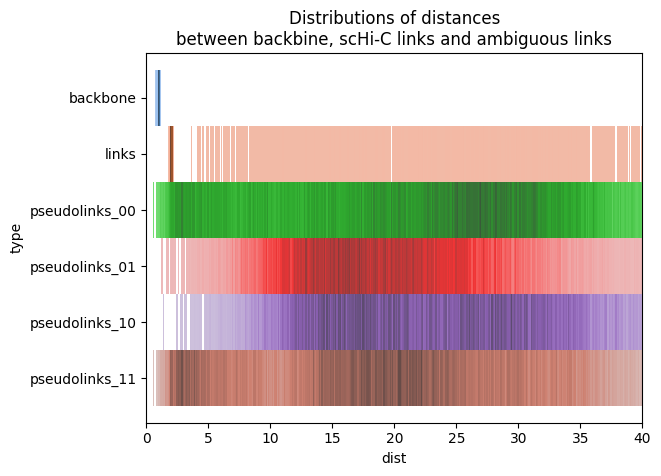

In [97]:
vmax = 40
step = 0.1
sns.histplot( df_dists_toplot.reset_index(drop=True).query(f'dist<{vmax}'),
        binwidth=step,
        x='dist', 
        y='type', 
        hue='type', 
        legend=False,
        common_norm=False
)
# plt.xscale('log')
plt.xlim([0, vmax])

plt.title('Distributions of distances\nbetween backbine, scHi-C links and ambiguous links')


#### Select uniquely resolved pairs

In [98]:
cutoff = 2.0 + 0.5

In [99]:
# Define phasing candidates:
phasing_candidates = []
for phases in [
    (0, 0),
    (0, 1),
    (1, 0),
    (1, 1)
]:
    phasing_candidates.append( 
        dfs_pseudophased[phases].query(f'dist<{cutoff}')
    )

phasing_candidates = pd.concat(phasing_candidates)

In [100]:
len(phasing_candidates)

17394

In [101]:
# Filter out the candidates that cannot be resolved uniquely:
phasing_candidates = phasing_candidates.reset_index().drop_duplicates('index').set_index('index')
len(phasing_candidates)

15130

In [102]:
col_mark = 'pair_type'

In [103]:
unique_idx_bins = df_ambiguous.groupby(
    ['bin1_unphased', 'bin2_unphased']
).count().query('readID==1').index

In [104]:
phased_idx_bins = phasing_candidates.set_index(
    ['bin1_unphased', 'bin2_unphased']
).index

In [105]:
phased_idx_bins_unique = phased_idx_bins.intersection(unique_idx_bins)

In [106]:
phased_idx_unique = phasing_candidates.reset_index()\
    .set_index(['bin1_unphased', 'bin2_unphased'])\
    .loc[phased_idx_bins_unique, 'index']

In [107]:
len(phased_idx_unique)

1775

In [108]:
# Assign phases:

df.loc[phased_idx_unique, 'phase0'] = \
    phasing_candidates.loc[phased_idx_unique, 'pseusophase0']
df.loc[phased_idx_unique, 'phase1'] = \
    phasing_candidates.loc[phased_idx_unique, 'pseusophase1']

df.loc[phased_idx_unique, 'chr1_phased'] = \
    phasing_candidates.loc[phased_idx_unique, 'chr1_phased']
df.loc[phased_idx_unique, 'chr2_phased'] = \
    phasing_candidates.loc[phased_idx_unique, 'chr2_phased']

df.loc[phased_idx_unique, col_mark] = f"resolved-{iteration}"

### Store new contacts

In [64]:
# df.loc[:, 'phase0'] = df.loc[:, 'phase0'].astype(str)
# df.loc[:, 'phase1'] = df.loc[:, 'phase1'].astype(str)

In [127]:
iteration = 3

In [128]:
resolution_prev = resolution
resolution = 100_000 #500_000
factor_conversion = resolution_prev/resolution

In [129]:
n_beads_prev = len(bin_table)
chromsizes_diploid_res_prev = get_beads_per_chromosomes(chromsizes_diploid, resolution_prev)

In [130]:
chromsizes_diploid_res     = get_beads_per_chromosomes(chromsizes_diploid, resolution)
chromsizes_res = get_beads_per_chromosomes(chromsizes, resolution)

genome_viewframe_diploid = bioframe.make_viewframe(chromsizes_diploid['length'])

bin_table = cooler.binnify(chromsizes_diploid['length'], resolution)
bin_table.to_csv(f"./bin_table_round{iteration}.csv")

chromsizes_diploid_res.to_csv(f"./chrom-sizes_round{iteration}.csv")

In [131]:
chr_offsets = chromsizes_res.cumsum().shift(1).replace(np.nan, 0).astype(int)

df.loc[:, 'bin1_unphased'] = df.loc[:, 'pos1']//resolution + df['chr1'].apply(lambda x: chr_offsets[x])
df.loc[:, 'bin2_unphased'] = df.loc[:, 'pos2']//resolution + df['chr2'].apply(lambda x: chr_offsets[x])

In [132]:
# Split pairs into ambiguous vs not: 
df_accepted, df_ambiguous, df = split_pairs(df, mark=False)
print('Ambiguous vs resolved:', len(df_ambiguous), len(df_accepted))

Ambiguous vs resolved: 1823169 16069


In [133]:
# bin1_phased and bin2_phased are phased binned coordinates
chr_offsets_diploid = chromsizes_diploid_res.cumsum().shift(1).replace(np.nan, 0).astype(int)

df_accepted.loc[:, 'bin1_phased'] = df_accepted.loc[:, 'pos1']//resolution + df_accepted['chr1_phased'].apply(lambda x: chr_offsets_diploid.loc[x, 'length'])
df_accepted.loc[:, 'bin2_phased'] = df_accepted.loc[:, 'pos2']//resolution + df_accepted['chr2_phased'].apply(lambda x: chr_offsets_diploid.loc[x, 'length'])

# Get the edges: 
df_edges = get_edges(df_accepted)

/tmp/ipykernel_2309672/2890387701.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_accepted.loc[:, 'bin1_phased'] = df_accepted.loc[:, 'pos1']//resolution + df_accepted['chr1_phased'].apply(lambda x: chr_offsets_diploid.loc[x, 'length'])
/tmp/ipykernel_2309672/2890387701.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_accepted.loc[:, 'bin2_phased'] = df_accepted.loc[:, 'pos2']//resolution + df_accepted['chr2_phased'].apply(lambda x: chr_offsets_diploid.loc[x, 'length'])


In [134]:
df_edges.to_csv(f"./edges_round{iteration}.csv")

### Interpolate the model and increase resolution

In [118]:
def model_interpolate(points, n):
    """
    Takes the numpy array of points and interpolates linearly into the n new points.
    """
    n1 = len(points)
    total_len = n1 - 1
    points_new = [points[0]]
    for i in range(1, n):
        curr_len = total_len * i / (n - 1)
        p1 = points[int(curr_len // 1)]
        if curr_len // 1 == n1 - 1:
            points_new.append(p1)
        else:
            p2 = points[int(curr_len // 1) + 1]
            alpha = curr_len % 1
            p = (p1[0] * (1 - alpha) + p2[0] * alpha, p1[1] * (1 - alpha) + p2[1] * alpha,
                 p1[2] * (1 - alpha) + p2[2] * alpha)
            points_new.append(p)
    return np.array(points_new)

In [119]:
bin_table = cooler.binnify(chromsizes_diploid['length'], resolution)
n_beads = len(bin_table)

In [120]:
resolution_prev, resolution, n_beads_prev, n_beads

(500000, 100000, 12412, 61940)

In [121]:
pos_prev = pos

In [122]:
# Interpolate within each chromosome individually:
pos_new = []

chr_pos_start = 0

for ch in chromsizes_diploid_res.index.values:
    
    n_beads_chr_prev = chromsizes_diploid_res_prev.loc[ch, 'length']
    n_beads_chr      = chromsizes_diploid_res.loc[ch, 'length']

    # Define chromosome end:
    chr_pos_end = chr_pos_start + n_beads_chr_prev
    pos_chr = pos_prev[chr_pos_start:chr_pos_end, :]
    pos_new.append( model_interpolate(pos_chr, n_beads_chr) )

    # Set the pointer to the chromosome start to the end of the current one:
    chr_pos_start = chr_pos_end

In [123]:
pos_new = np.concatenate(pos_new)

In [124]:
pos_new.shape, n_beads

((61940, 3), 61940)

In [125]:
starting_pos = pos_new # (factor_conversion**(1/3.))*pos_new

In [126]:
np.save( f"starting_model_round{iteration}.npy", starting_pos )

In [347]:
# distances_backbone = get_distances_backbone(starting_pos, chromsizes_diploid_res)
# pd.DataFrame( distances_backbone ).describe()